In [124]:
import numpy as np
import torch
from pyhessian import hessian # Hessian computation
import torch.nn as nn
import matplotlib.pyplot as plt

from mnist1d.data import get_dataset_args, get_dataset
%matplotlib inline

seed=92

YOU MUST ALLOCATE THE DEPTH YOU WANT !

In [125]:
DEPTH=4

In [126]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [127]:
def get_total_params_function(depth, units):
    total_params = 0
    
    for layer in range(1, depth + 2):
        params = units[layer] * ( units[layer - 1] + 1 )
        total_params += params
    
    return total_params

In [128]:

class CustomFCNN(nn.Module):
    def __init__(self, depth, units, input_size=40, output_size = 10):
        super(CustomFCNN, self).__init__()
        self.depth = depth
        self.units = units
        self.input_size = input_size
        self.output_size = output_size
        
        layers = []
        for i in range(depth):
            layers.append(nn.Linear(units[i], units[i+1]))
            layers.append(nn.ReLU())

        # output layer
        layers.append(nn.Linear(units[-2], units[-1]))
        self.layers = nn.Sequential(*layers)

        # He initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):
        return self.layers(x)

    def get_total_params(self): 
        return get_total_params_function(self.depth, self.units)


In [129]:
     
def get_units_equal(input_size, output_size, depth, params_limit=15500):
    units = [input_size] 
    possible_num_of_unit = 0
    test = 1
    
    while True:
        test_units = [input_size] + [test] * depth + [output_size] 
        test_params = get_total_params_function(depth, test_units)
        
        if test_params > params_limit:
            break
        else:
            possible_num_of_unit = test
            test += 1
    
    units.extend([possible_num_of_unit] * depth) 
    units.append(output_size)

    return units


In [130]:
# set random seed to reproduce the work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

#count=101

Please pay attention to setting the dataset path (You have to change your own dataset path)

In [133]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y
    
# load data 
data = get_dataset(get_dataset_args(), path='./mnist1d_data.pkl', download=True)
x_train, x_test = torch.Tensor(data['x']), torch.Tensor(data['x_test'])
y_train, y_test = torch.LongTensor(data['y']), torch.LongTensor(data['y_test'])

# create customized dataset 
train_dataset=CustomDataset(x_train,y_train)
test_dataset=CustomDataset(x_test,y_test)

# create DataLoader
train_loader=DataLoader(train_dataset,shuffle=True)
test_loader=DataLoader(test_dataset,shuffle=True)

for inputs, targets in train_loader:
    break

# loss function
criterion=torch.nn.CrossEntropyLoss()

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl


PLEASE LOAD THE MODEL WITH THE DEPTH SET ABOVE

In [131]:
# get model
units=get_units_equal(input_size=40,output_size=10,depth=DEPTH,params_limit=15000+500)
model=CustomFCNN(DEPTH,units,input_size=40,output_size=10 )

# ------ Please load(change) the model located at the specified path ------
model.load_state_dict(torch.load('model_1-11/w__depth_{0}.pth'.format(DEPTH)))
model.eval()
model=model.cuda()
inputs,targets=inputs.cuda(),targets.cuda()

# create hessian computation module
hessian_comp=hessian(model,criterion,data=(inputs,targets), cuda=True)

# get the top eigenvector
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl


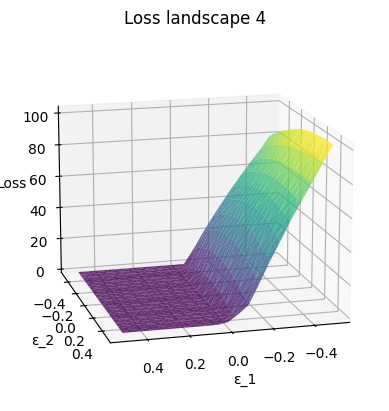

In [132]:
# single model
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb


# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams1 = np.linspace(-0.5, 0.5, 21).astype(np.float32)
lams2 = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []
loss_list2 = []


# model 1
model_perb1=CustomFCNN(DEPTH,units,input_size=40,output_size=10 )
model_perb1.eval()
model_perb1 = model_perb1.cuda()

model_perb2=CustomFCNN(DEPTH,units,input_size=40,output_size=10 ) 
model_perb2.eval()
model_perb2 = model_perb2.cuda()


for lam1 in lams1:
    for lam2 in lams2:
        model_perb1 = get_params(model, model_perb1, top_eigenvector[0], lam1)
        model_perb2 = get_params(model_perb1, model_perb2, top_eigenvector[1], lam2)
        loss_list.append((lam1, lam2, criterion(model_perb2(inputs), targets).item()))   
        

loss_list = np.array(loss_list)
loss_list2 = np.array(loss_list2)
                         
fig = plt.figure()
#landscape = fig.gca(projection='3d')
landscape=fig.add_subplot(projection='3d')
landscape.plot_trisurf(loss_list[:,0], loss_list[:,1], loss_list[:,2],alpha=0.8, cmap='viridis')
                       #cmap=cm.autumn, #cmamp = 'hot')


landscape.set_title('Loss landscape {0}'.format(DEPTH))
landscape.set_xlabel('ε_1')
landscape.set_ylabel('ε_2')
landscape.set_zlabel('Loss')

landscape.view_init(elev=15, azim=75)
landscape.dist = 6
plt.show()